# Анализ рынка видеоигр

## План работы:
___
##### [Шаг 1. Изучение данных](#1-link)
##### [Шаг 2. Предобработка данных](#2-link)
##### [Шаг 3. Анализ данных](#3-link)
* [Анализ и определение наиболее актуальных платформ/периода для анализа](#6-link)
* [Определение границ датасета для дальнейшего использования в анализе](#7-link)
* [Анализ взаимосвязи продаж и оценок игр в СМИ](#8-link)
* [Анализ выручки от продажи игр в разрезе платформ](#9-link)
* [Анализ выручки от продажи игр в разрезе жанров](#10-link)
* [Портрет покупателя для каждого региона продаж](#11-link)

##### [Шаг 4. Проверка гипотез](#4-link)
* [Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#12-link)
* [Средние пользовательские рейтинги жанров Action и Sports разные](#13-link)

##### [Шаг 5. Общий вывод](#5-link)


# Шаг 1. Изучение данных <a id='1-link'></a>

Импортируем библиотеки, необходимые для работы над проектом:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns

Вводим переменную для исходной анализируемой таблицы:

In [2]:
data = pd.read_csv('C:\games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Значительное число пропусков обнаружено в столбцах с оценками и рейтингом игр (от 6 до 8 тыс. строк),также около 300 строк находится в столбце с информацией о годе выпуска.

Исходные данные содержат следующие столбцы:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# Шаг 2. Предобработка данных<a id='2-link'></a>

Мы привели названия столбцов к нижнему регистру

In [3]:
data.columns = data.columns.str.lower()

#### Обработка пропусков

Проанализируем столбцы на наличие пропусков

In [4]:
data.isnull().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

In [5]:
data.query('critic_score.isnull()', engine='python').describe()
data.query('critic_score.isnull()', engine='python').groupby('platform')['name'].count().sort_values(ascending=False).head(10)

platform
DS      1434
PS       997
PS2      863
PSP      747
Wii      735
PS3      511
GBA      384
3DS      352
X360     346
N64      319
Name: name, dtype: int64

In [6]:
data.query('user_score.isnull()', engine='python').describe()
data.query('user_score.isnull()', engine='python').groupby('platform')['name'].count().sort_values(ascending=False).head(10)

platform
PS     990
DS     879
PS2    680
PSP    665
PS3    367
Wii    320
N64    319
GBA    305
3DS    290
PSV    280
Name: name, dtype: int64

In [7]:
data.query('rating.isnull()', engine='python').describe()
data.query('rating.isnull()', engine='python').groupby('platform')['name'].count().sort_values(ascending=False).head(10)

platform
PS     989
DS     878
PS2    680
PSP    665
PS3    379
N64    319
Wii    318
GBA    300
3DS    292
PSV    279
Name: name, dtype: int64

Судя по всему пропуски в столбцах с информацией об оценках и рейтингах главным образом встречаются для старых игр, которым более 5-10 лет. Соответственно при взгляде на данные в разрезе платформ наибольшее количество пропусков относится к наиболее старшим поколениям

In [8]:
data['year_of_release'].fillna(data.groupby('name')['year_of_release'].transform('median').round(), inplace = True)
data['year_of_release'].isnull().sum()

146

Оставшиеся строки не содержащие данные о годе выпуска мы удаляем

In [9]:
data = data.loc[data['year_of_release'] != 0]

Аббервиатура "tbd" означает неопределенный статус, по причине недостаточности объема данных для выставления рейтинга. 
Заполнение пропусков и подобных значений не целесообразно и может существенно исказить выводы., поэтому нра текущий момент никаких изменений внесено не будет

In [10]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

2 строки с пропуском имени и данных об оценке мы удалим 

In [11]:
data.dropna(subset=['name'], inplace=True)

In [12]:
data.isnull().mean()

name               0.000000
platform           0.000000
year_of_release    0.008736
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513133
user_score         0.545863
rating             0.404715
dtype: float64

Мы рассчитали суммарные продажи во всех регионах

В столбце рейтинг мы привели систему оценок к актуальной шкале

In [13]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [14]:
data['rating'] = data['rating'].replace('K-A', 'E')

In [15]:
data['user_score'] = data['user_score'].astype('float32')

In [16]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16567.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000,7590.000000
mean,2006.490433,0.263302,0.145045,0.077625,0.047343,68.967679,7.125076
std,5.862690,0.813565,0.503359,0.308871,0.186742,13.938165,1.500002
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Мы проанализировали данные на наличие необычных значений. Все столбцы в которых содержится числовая инфомрация соответствуют ожиданиям и пониманию

Совокупные данные о продажах игр посчитаны в столбец total sales

In [17]:
data['total_sales']= data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16567 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float32
 10  rating           9949 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: float32(1), float64(7), object(4)
memory usage: 1.6+ MB


##### В ходе предобработки были осуществлены следующие преобразования:
1. Названия колонок приведены к нижнему регистру
2. Более подробно изучены значения в каждом столбце на предмет наличия ошибочных значений.
3. Заполнена часть пустых значений в годах релиза в зависимости от года релиза на других платформах. Оставшаяся часть удалена.
4. Значения "tbd" в user_score объяснены и заменены на NaN.
5. Посчитаны суммарные продажи во всех регионах и сохранены в столбце sales_sum


# Шаг 3. Анализ данных<a id='3-link'></a>

Для того, чтобы проанализировать какое количество игр выходило в разные годы построим график

Text(0.5, 1.0, 'Количество выпущенных игр в разные годы')

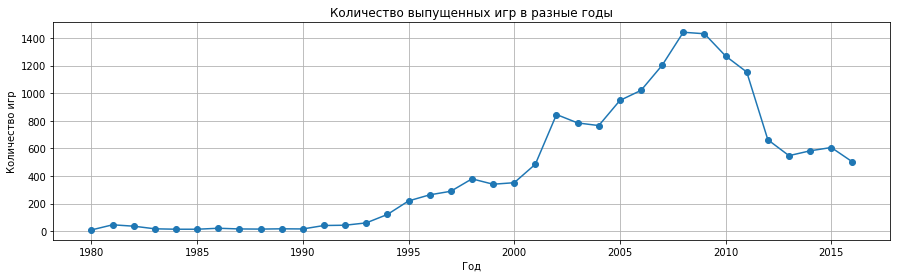

In [19]:
data.groupby('year_of_release')['name'].count().plot(figsize = (15, 4), grid = True, style = '-o')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.title ('Количество выпущенных игр в разные годы')

Судя по графику на рост количества игр в начале 2000х могло повлиять технологическое развитие отрасли, спад в конце 2000х вероятнее всего обусловлен мировым финансовым кризисом 2008 года, в связи с которым финансирование новых проектов было сокращено.

Мы рассчитали сколько в среднем приносила каждая игра за год своего существования на рынке и показали совокупные показатели в разрезе платформ, жанров

In [20]:
data['existing_period'] = 2017 - data['year_of_release']
data['revenue_per_year'] = data['total_sales'] / data['existing_period']

In [21]:
data.pivot_table(index=['platform'], values='revenue_per_year', aggfunc='sum').sort_values(by='revenue_per_year', ascending=False).head(10)

,revenue_per_year
platform,
PS4,168.530833
PS3,163.500420
X360,155.177190
Wii,110.780946
PS2,97.396399
DS,88.185206
XOne,78.983333
3DS,78.688534
PC,41.570479


In [22]:
data.pivot_table(index=['genre'], values='revenue_per_year', aggfunc='sum').sort_values(by='revenue_per_year', ascending=False).head(10)

,revenue_per_year
genre,
Action,278.059765
Shooter,196.875057
Sports,181.148556
Role-Playing,137.985025
Misc,99.880394
Racing,74.643785
Platform,73.744406
Fighting,49.679100
Simulation,44.238744


Как мы могли заметить, в рассматриваемом датасете наиболее прибыльными являются приставки производства компании Sony. Как мы видим на текущий момент наиболее финансово успешной консолью является PS4, ее идеологический конкурент XOne находится на 7 месте, и отстает более чем в 2 раза по уровню ежегодной выручки. Консоли предыдущего поколения занимают 2 и 3 места. PC является наименее прибыльной платформой на равне с первой выпущенной PS.

Данный анализ помогает понять историческую предрасположенность пользователей, где голос в пользу платформу или жанра был выражен не просто в качестве мнения, а был запечатлен монетой.

###  Анализ и определение наиболее актуальных платформ/периода для анализа<a id='6-link'></a>

Мы визуализировали продажи по всем платформам по имеющемуся датасету

In [23]:
all_platforms = ( data.pivot_table(index = 'year_of_release', columns = 'platform', 
                             values = 'total_sales', aggfunc = 'sum', fill_value = 0) )

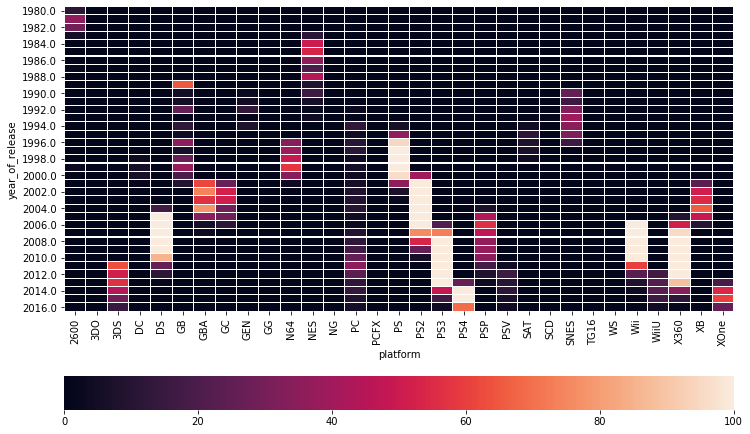

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(all_platforms, linewidths=.1, ax=ax, cbar_kws= {'orientation': 'horizontal'}, vmax = 100)

Очевидно, что у каждой платформы есть свой жизненный цикл и уровень популярности за этот период. 
- Так к примеру PS - 6 лет, PS2 - 8 лет, PS3 - 7 лет. При этом переходный период пользователей на следующее поколение составляет в среднем 1-2 года и спрос на игры предыдущего поколения начинает стремительно падать, так скажем настает период распродажи остатков. 

- Наиболее успешной для Microsoft удалась X360, которая показала сопоставимые продажи с главными конкурентами и сохраняла их около 8 лет, XOne не удалось повторить успех своего предшественника.

- В аналогичный период успеха добилась компания Nintendo со своими DS и Wii однако их период активных продаж составил всего около 4-5 лет. Причем новое поколение именно портативной версии консоли, которая стала гибридом двух предыдущих стало пользоваться успехом. С учетом анонса выхода нового поколения на 2017 год, стоит проанализировать текущих представителей.

### Определение границ датасета для дальнейшего использования в анализе<a id='7-link'></a>

В ходе анализа популярности платформ было определено, что популярностью пользуются главным образом игры, выпускаемые на консоли таких производителей как Sony, Microsoft и Nintendo. Мы определили жизненный цикл, сменяемость и относительную распространенность/популярность консолей. 

Наиболее актуальными являются PS4, XOne и 3DS. Однако для полноты картины необходимо учесть также информацию о предыдущем поколении, а именно PS3, X360 и DS/Wii.

Соответственно срез датасета мы будем осуществлять именно по таким параметрам без привязки ко времени выхода игр, т.к. для понимания предпочтений эти параметры будут первостепенными.

Геймплейные особенности, позиционирование консолей и фансообщество сформировало отличительные черты и преимущества консолей.

In [25]:
top_platforms_list = ['Wii', 'DS', 'X360', 'PS3','PS4', '3DS', 'XOne']

In [26]:
top_platforms = data.query('@top_platforms_list in platform')

In [27]:
top_platforms_pivot = ( top_platforms.pivot_table(index = 'year_of_release', columns = 'platform', 
                             values = 'total_sales', aggfunc = 'sum', fill_value = 0) )

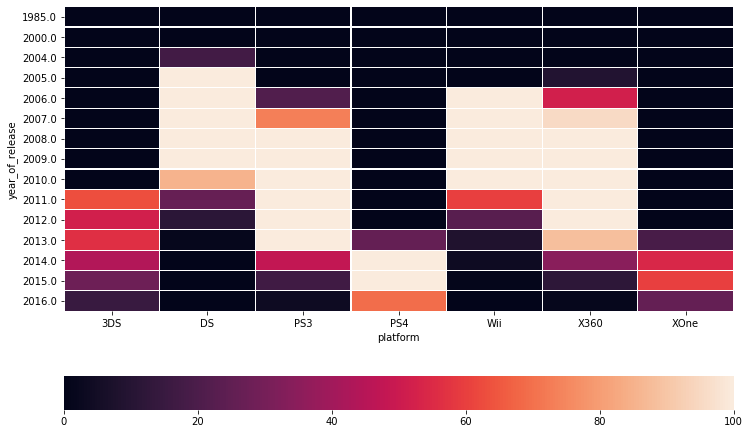

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(top_platforms_pivot, linewidths=.1, ax=ax, cbar_kws= {'orientation': 'horizontal'}, vmax = 100)

Актуальным периодом для планирования рекламы на 2017 год: 2005 год - настоящее время. Данный интервал позволит наиболее точно определить портрет пользователя каждой консоли и их жанровые предпочтения.

In [29]:
df = top_platforms.query('year_of_release >= 2005')

#### Анализ взаимосвязи продаж и оценок игр в СМИ<a id='8-link'></a>

### PS4

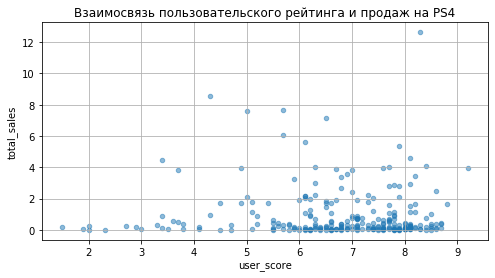

In [30]:
df.query('platform == "PS4"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на PS4')

plt.show;

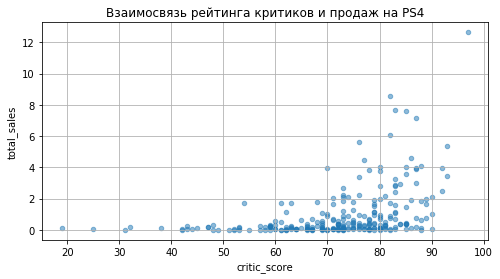

In [31]:
df.query('platform == "PS4"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на PS4');

### PS3

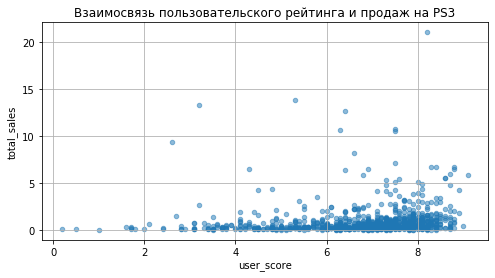

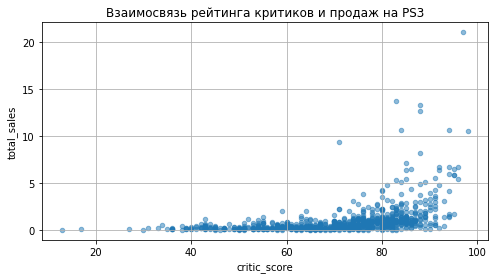

In [32]:
df.query('platform == "PS3"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на PS3');

plt.show

df.query('platform == "PS3"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на PS3');

### XOne

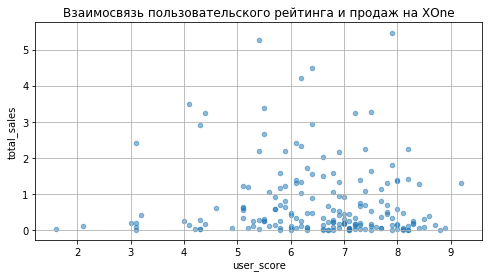

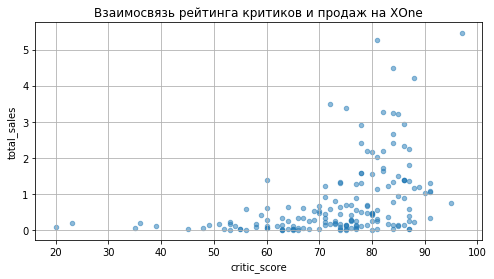

In [33]:
df.query('platform == "XOne"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на XOne');

plt.show

df.query('platform == "XOne"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на XOne');

### X360

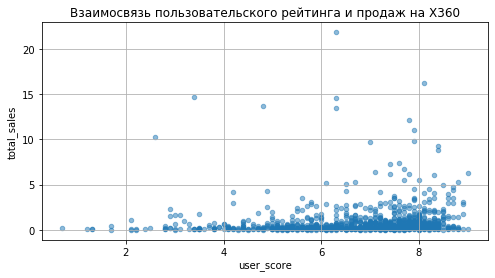

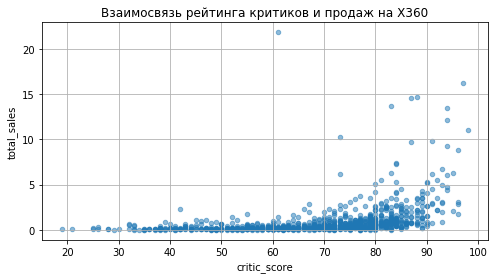

In [34]:
df.query('platform == "X360"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на X360');

plt.show

df.query('platform == "X360"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на X360');

### Wii

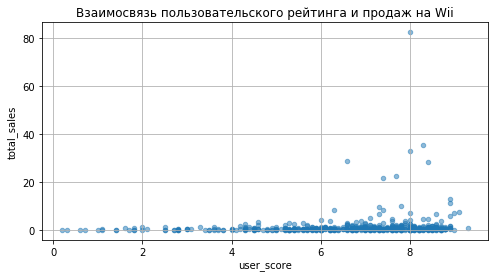

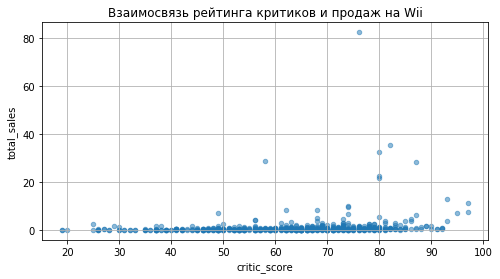

In [35]:
df.query('platform == "Wii"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на Wii');

plt.show

df.query('platform == "Wii"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на Wii');

### DS

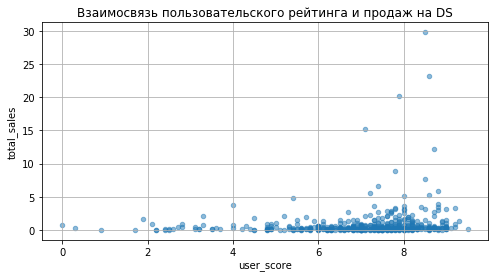

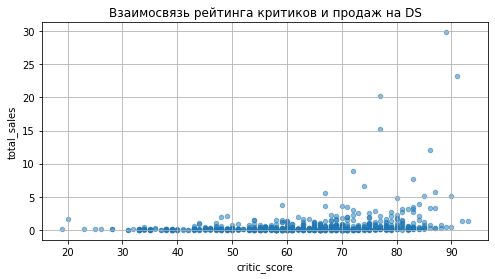

In [36]:
df.query('platform == "DS"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на DS');

plt.show

df.query('platform == "DS"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на DS');

### 3DS

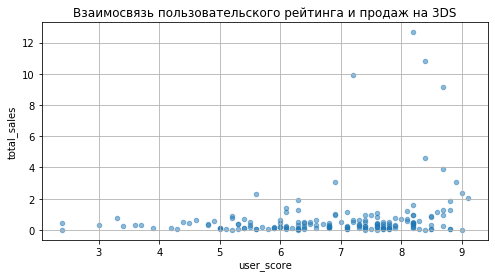

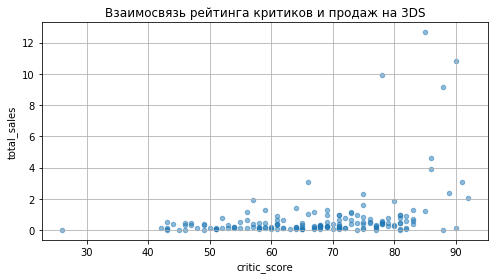

In [37]:
df.query('platform == "3DS"').plot(kind = 'scatter',
        x = 'user_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь пользовательского рейтинга и продаж на 3DS');

plt.show

df.query('platform == "3DS"').plot(kind = 'scatter',
        x = 'critic_score',
        y = 'total_sales',
        alpha = 0.5,
        figsize = (8, 4), grid=True)
plt.title('Взаимосвязь рейтинга критиков и продаж на 3DS');

Зависимость выручки от мнения пользователей/критиков разнится  для каждого производителя приставок, но все же общая тенденция более успешных продаж при более высокой оценке сохраняется.

Оценим коэффициенты корреляции для наиболее актуальных платформ: Wii, PS4 и XOne

In [38]:
df.query('platform == "PS4"')['user_score'].corr(df['total_sales'])

-0.031957109005188285

In [39]:
df.query('platform == "PS4"')['critic_score'].corr(df['total_sales'])

0.40656790206178095

In [40]:
df.query('platform == "XOne"')['user_score'].corr(df['total_sales'])

-0.06892505319711206

In [41]:
df.query('platform == "XOne"')['critic_score'].corr(df['total_sales'])

0.4169983280084017

In [42]:
df.query('platform == "Wii"')['user_score'].corr(df['total_sales'])

0.11346698245515327

In [43]:
df.query('platform == "Wii"')['critic_score'].corr(df['total_sales'])

0.17790341900655177

Мы видим аналогичную ситуацию для PS4 и XOne: мнение критиков имеет умеренное влияние на объем продаж, мнение пользователей влияния не имеет.

Пользователи Wii в большей степени обращают внимание на отзывы пользователей, однако влияние критиков менее ощутимо, чем у других платформ. 

### Анализ выручки от продажи игр в разрезе платформ<a id='9-link'></a>

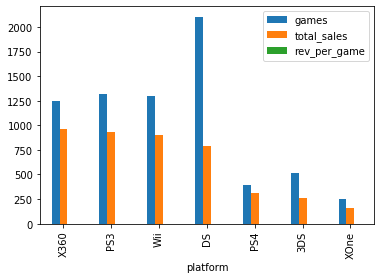

In [44]:
top_platforms_summury = ( df.groupby('platform')
                       .agg({'year_of_release': 'count', 'total_sales':'sum'})
                       .rename(columns = {'year_of_release': 'games'})
                       .sort_values(by = 'total_sales', ascending = False) )

top_platforms_summury['rev_per_game'] = top_platforms_summury['total_sales'] / top_platforms_summury['games']
top_platforms_summury
top_platforms_summury.plot(kind='bar');

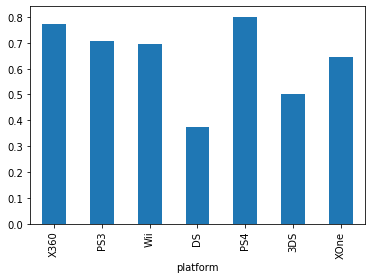

In [45]:
top_platforms_summury['rev_per_game'].plot(kind='bar');

В таблице выше представлены данные о выпущенном количестве игр, суммарной выручке и средней выручке на 1 выпущенную игру.
Как видно на графиках, средняя выручка на игру на PS3, X360 и Wii сопоставима. PS4 лидирует и на несколько пунктов обходит Xone, а DS значительно уступает в данном показателе, общий сопоставимый уровень выручки достигнут за счет значительно большего количества выпущенных игр.


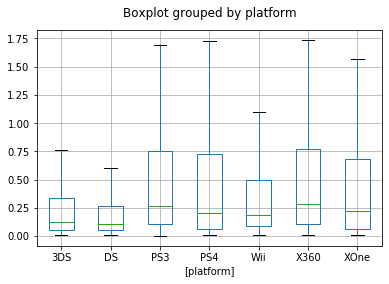

In [46]:
( df.boxplot(column=['total_sales'], by=['platform'], showfliers = False) )
plt.title(' ');

Данный график показывает нам, что наиболее прибыльные отдельные игры были выпущены на консоли Microsoft и Sony. Их более старшие модели уже соответствуют своим предшественникам. Игры на Nintendo в среднем менее прибыльны, но Wii наиболее успешен, судя по текущей визуализации. Медианные значения находятся на сопоставимых уровнях, но их положение относительно средних значений говорит о том, что на каждой из платформ есть игры, которые принесли напорядок больше выручки по сравнению с остальными играми.

### Анализ выручки от продажи игр в разрезе жанров<a id='10-link'></a>

In [47]:
df.query('["PS4", "PS3"] in platform ').groupby('genre')['total_sales'].sum().sort_values(ascending = False)

genre
Action          395.97
Shooter         281.10
Sports          189.01
Role-Playing    102.69
Racing           83.64
Fighting         59.76
Misc             53.43
Platform         37.49
Adventure        28.62
Simulation       11.54
Strategy          5.47
Puzzle            0.61
Name: total_sales, dtype: float64

In [48]:
df.query('["X360", "XOne"] in platform ').groupby('genre')['total_sales'].sum().sort_values(ascending = False)

genre
Shooter         337.07
Action          275.93
Sports          164.89
Misc             96.45
Role-Playing     81.94
Racing           74.04
Fighting         39.77
Adventure        17.57
Simulation       14.75
Platform         12.22
Strategy         10.43
Puzzle            0.87
Name: total_sales, dtype: float64

In [49]:
df.query('["3DS", "Wii", "DS"] in platform ').groupby('genre')['total_sales'].sum().sort_values(ascending = False)

genre
Misc            359.86
Sports          324.89
Action          284.16
Role-Playing    222.08
Simulation      191.62
Platform        186.90
Racing          111.45
Puzzle          100.04
Adventure        68.32
Fighting         41.00
Shooter          37.11
Strategy         21.38
Name: total_sales, dtype: float64

Мы проанализировали доходность жанров для каждого производителя платформ:

- для Sony и Microsoft тройка наиболее прибыльных жанров одинакова, это Shooter, Action и Sports.
- для Nintendo разрыв в прибыльности не такой наглядный, в топ вошли Misc, Sports и Action, а также RP, Simulation, Platform, Racing и Puzzle (который не приносит прибыли на других платформах), а жанр Shooter значительно менее прибылен.

## Портрет покупателя для каждого региона продаж<a id='11-link'></a>

Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [50]:
region_sales_by_platform = ( df.groupby('platform').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'other_sales':'sum', 'total_sales':'sum', 'revenue_per_year':'sum'})
 .sort_values(by = 'revenue_per_year', ascending = False).reset_index() )

region_sales_by_platform['share_na'] = region_sales_by_platform['na_sales'] / region_sales_by_platform['total_sales']  
region_sales_by_platform['share_eu'] = region_sales_by_platform['eu_sales'] / region_sales_by_platform['total_sales']  
region_sales_by_platform['share_jp'] = region_sales_by_platform['jp_sales'] / region_sales_by_platform['total_sales'] 
region_sales_by_platform['share_other'] = region_sales_by_platform['other_sales'] / region_sales_by_platform['total_sales']  
region_sales_by_platform

,platform,na_sales,eu_sales,jp_sales,other_sales,total_sales,revenue_per_year,share_na,share_eu,share_jp,share_other
0,PS4,108.74,141.09,15.96,48.35,314.14,168.530833,0.346151,0.449131,0.050805,0.153912
1,PS3,391.60,328.97,79.52,135.10,935.19,163.500420,0.418738,0.351768,0.085031,0.144463
2,X360,599.15,269.79,12.33,85.34,966.61,155.177190,0.619847,0.279109,0.012756,0.088288
3,Wii,494.01,261.48,69.05,78.77,903.31,110.780946,0.546889,0.289469,0.076441,0.087202
4,DS,373.05,184.79,171.35,57.80,786.99,86.856120,0.474021,0.234806,0.217728,0.073444
5,XOne,93.12,51.59,0.34,14.27,159.32,78.983333,0.584484,0.323814,0.002134,0.089568
6,3DS,83.11,61.46,100.62,13.32,258.51,78.687357,0.321496,0.237747,0.389231,0.051526


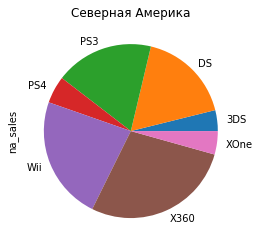

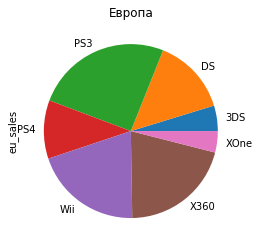

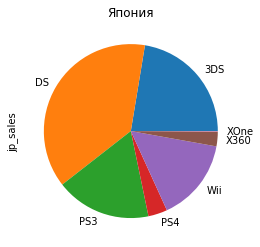

In [51]:
region_sales_by_platform.groupby('platform')['na_sales'].sum().plot.pie()
plt.title('Северная Америка')
plt.show()
region_sales_by_platform.groupby('platform')['eu_sales'].sum().plot.pie()
plt.title('Европа')
plt.show()
region_sales_by_platform.groupby('platform')['jp_sales'].sum().plot.pie()
plt.title('Япония')
plt.show()

По сводной таблице и графикам можно сделать следующие выводы:

- na и eu рынки очень схожи, они дают Sony 70% выручки, jp всего 5%
- консоли Microsoft наиболее популярны в na, что можно попробовать объяснить поддержкой своего производителя:), и что интересно, X360 пользовался в jp большей популярностью, чем PS3/4 однако в структуре выручки XOne jp составляет всего     
- консоли 3DS и DS имею более широкое распространение и наибольшие доли присутствия в jp по сравнению с прочими

В целом данная визуализация дает четкое представление о наиболее прибыльных платформах и их распределении по регионам.

In [52]:
region_sales_by_genre = ( df.groupby('genre').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'other_sales':'sum', 'total_sales':'sum', 'revenue_per_year':'sum'})
 .sort_values(by = 'revenue_per_year', ascending = False).reset_index() )

region_sales_by_genre['share_na'] = region_sales_by_genre['na_sales'] / region_sales_by_genre['total_sales']  
region_sales_by_genre['share_eu'] = region_sales_by_genre['eu_sales'] / region_sales_by_genre['total_sales']  
region_sales_by_genre['share_jp'] = region_sales_by_genre['jp_sales'] / region_sales_by_genre['total_sales'] 
region_sales_by_genre['share_other'] = region_sales_by_genre['other_sales'] / region_sales_by_genre['total_sales']  
region_sales_by_genre

,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,revenue_per_year,share_na,share_eu,share_jp,share_other
0,Action,468.34,304.41,77.75,105.56,956.06,207.840440,0.489865,0.318401,0.081323,0.110411
1,Shooter,351.21,211.72,16.00,76.35,655.28,163.094930,0.535969,0.323099,0.024417,0.116515
2,Sports,351.98,221.16,35.14,70.51,678.79,132.894856,0.518540,0.325815,0.051769,0.103876
3,Role-Playing,165.53,85.96,124.89,30.33,406.71,92.688158,0.406998,0.211355,0.307074,0.074574
4,Misc,264.71,141.27,59.31,44.45,509.74,74.222985,0.519304,0.277141,0.116353,0.087201
5,Racing,120.56,103.03,15.06,30.48,269.13,41.836504,0.447962,0.382826,0.055958,0.113254
6,Platform,114.71,68.29,31.74,21.87,236.61,35.534203,0.484806,0.288618,0.134145,0.092431
7,Simulation,110.10,59.79,29.77,18.25,217.91,28.718548,0.505254,0.274379,0.136616,0.083750
8,Fighting,73.49,33.70,19.26,14.08,140.53,27.075580,0.522949,0.239806,0.137053,0.100192
9,Adventure,56.91,31.57,15.55,10.48,114.51,21.181925,0.496987,0.275696,0.135796,0.091520


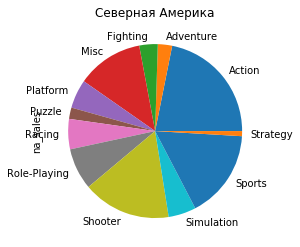

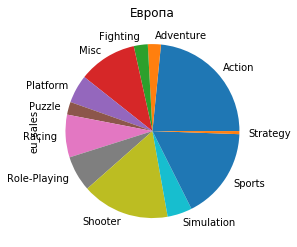

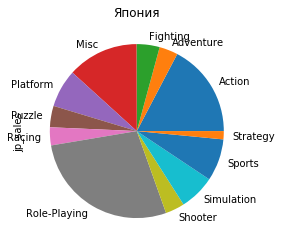

In [53]:
region_sales_by_genre.groupby('genre')['na_sales'].sum().plot.pie()
plt.title('Северная Америка')
plt.show()
region_sales_by_genre.groupby('genre')['eu_sales'].sum().plot.pie()
plt.title('Европа')
plt.show()
region_sales_by_genre.groupby('genre')['jp_sales'].sum().plot.pie()
plt.title('Япония')
plt.show()

Наиболее прибыльные жанры: Action, Shooter, Sports, RP и Misc. В разрезе жанров na и eu вновь показывают схожие результаты, а вот jp наиболее популярны RP игры, Strategy и Puzzle, что можно объяснить предрасположенностью к игре на Nintendo, где игры этих жанров представлены больше всего.

In [54]:
rating_sales = ( df.groupby('rating').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'total_sales':'sum'})
.sort_values(by = 'total_sales', ascending = False) )
rating_sales

,na_sales,eu_sales,jp_sales,total_sales
rating,,,,
E,750.58,440.88,131.40,1460.87
M,530.22,345.72,37.85,1037.25
T,338.94,174.24,52.73,633.30
E10+,269.19,140.86,31.36,489.04
EC,1.23,0.00,0.00,1.31


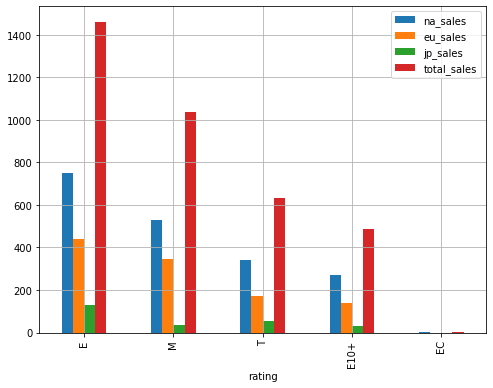

In [55]:
rating_sales.plot(kind = 'bar', figsize = (8, 6), grid = True);

В рассматриваемом периоде резонно анализировать следующие типы рейтингов: M (17лет+), E (0+), T (13+) и E10+ (10+). Как мы видим из графика, наиболее прибыльным являются игры, подходящие люям любого возраста, это можно обосновать тем, что потенциально данные игры разрабатываются для наиболее широкого круга людей, чаще всего ориентированы на детей или развлечения в компании. На втором месте идут игры с наиболее жестким рейтингом, как правило это трипл A проекты, у которых сформирована своя фан база, у них наивысшие бюджеты на разработку и соответствующий уровень качества. В целом влияние данных рейтингов весьма косвенно и условно, т.к. рейтинг в конечном счете является лишь рекомендацией, и не ограничивает к покупке, соответственно оценки игр и предрасположенность покупателя к самой игре/платформе.

##### Портрет NA пользователя 
Из актуальных платформ предпочитает играть на PS и XBox. Активнее покупателей из других регионов. Больше всего любит Shooter, Action, Sport, Misc и RP. 
##### Портрет EU пользователя 
Из актуальных платформ предпочитает играть на PS. Любимые жанры аналогичны NA. 
##### Портрет JP пользователя 
Предпочитает разнообразные игры на Nintendo, главным образом RP и Action. Если все же отдает предпочтение другой консоли, то это PS.

# Шаг 4. Проверка гипотез<a id='4-link'></a>

##### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<a id='12-link'></a>

Период для сравнения рейтингов выберем 2014 - тек. год, (с момента выхода XOne)

In [56]:
data.query('platform == "XOne" and year_of_release > 2013')['user_score'].agg({'count', 'mean'})

count    165.000000
mean       6.594543
Name: user_score, dtype: float64

In [57]:
data.query('platform == "PC" and year_of_release > 2013')['user_score'].agg({'count', 'mean'})

count    123.000000
mean       6.316258
Name: user_score, dtype: float64

При сравнении за сопоставимый период средняя оценка пользователей выше у XOne.
- Н0: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
- Н1: cредние пользовательские рейтинги платформ Xbox One и PC не равны.

In [58]:
alpha = .1
results1 = ( st.ttest_ind(data.query('platform == "PC" and year_of_release > 2013')['user_score'].dropna(), 
             data.query('platform == "XOne"')['user_score'].dropna(), equal_var = False) )

if (results1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
results1.pvalue

Не получилось отвергнуть нулевую гипотезу


0.26837979579100885

Вывод: По итогам проверки мы можем сделать вывод о том, что средний пользовательский рейтинг игр на XOne и PC с высокой вероятностью не отличается

#### Средние пользовательские рейтинги жанров Action и Sports разные.<a id='13-link'></a>

In [59]:
data.query('genre == "Action"')['user_score'].agg({'count', 'mean'})

count    1830.000000
mean        7.054029
Name: user_score, dtype: float64

In [60]:
data.query('genre == "Sports"')['user_score'].agg({'count', 'mean'})

count    1103.000000
mean        6.961194
Name: user_score, dtype: float64

При сравнении за сопоставимый период средняя оценка пользователей выше у Action.
- H0: cредние пользовательские рейтинги Action и Sport игр одинаковые.
- H1: cредние пользовательские рейтинги Action и Sport игр не равны.

In [61]:
results2 = (st.ttest_ind(df.query('genre == "Sports"')['user_score'].dropna(), 
             df.query('genre == "Action"')['user_score'].dropna(), equal_var = False))

if (results2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
results2.pvalue

Отвергаем нулевую гипотезу


1.2621957601956954e-09

Вывод: По итогам проверки мы можем сделать вывод о том, что средний пользовательский рейтинг Sport игр  с высокой вероятностью  ниже, чем Action игр.

# Шаг 5. Общий вывод<a id='5-link'></a>

- Наиболее ценный период для анализа данных - период с 2006 года, т.к. начиная с этого периода индустрия пережила пик своего развития, а также были сформированы основные предпочтения покупателей в отношении производителей платформ. 
- Наиболее востребованные жанры: Action, Shooter, Sport и RP.
- Предпочтения покупателей, как жанровые, так и при выборе платформы отличаются в большей степени отличия видны между JP и прочими регионами.
- Возрастной рейтинг ESRB и рейтинг пользователей не является определяющим продажи фактором. А вот рейтинг критиков важен для продаж во всех регионах.
- Была осуществлена проверка гипотез, описанных в задании, в результате чего можно сделать вывод о том, что рейтинг PC и XOne игр с высокой вероятностью не отличается, а вот рейтинг Sport игр ниже, чем Action